In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import time

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.8.0
Running on TPU  ['10.125.161.114:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.125.161.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.125.161.114:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
from google.colab import drive

drive.mount('/gdrive', force_remount = True)

Xd = pd.read_pickle("/gdrive/MyDrive/RML2016.10a_dict.pkl")

Mounted at /gdrive


In [ ]:
# Load the dataset ...
#  You will need to seperately download or generate this file

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

print(X_train.transpose((0,2,1)).shape)

X_train = X_train.transpose((0,2,1))
X_test = X_test.transpose((0,2,1))

(110000, 2, 128) [2, 128]
(110000, 128, 2)


In [ ]:
class peel_the_layer(tf.keras.layers.Layer): 
      def __init__(self):    
          ##Nothing special to be done here
          super(peel_the_layer, self).__init__()
          
      def build(self, input_shape):
          ##Define the shape of the weights and bias in this layer
          ##This is a 1 unit layer. 
          units=1
          ##last index of the input_shape is the number of dimensions of the prev
          ##RNN layer. last but 1 index is the num of timesteps
          self.w=self.add_weight(name="att_weights", shape=(input_shape[-1], units), initializer="normal") #name property is useful for avoiding RuntimeError: Unable to create link.
          self.b=self.add_weight(name="att_bias", shape=(input_shape[-2], units), initializer="zeros")
          super(peel_the_layer,self).build(input_shape)
          
      def call(self, x):
          ##x is the input tensor..each word that needs to be attended to
          ##Below is the main processing done during training
          ##K is the Keras Backend import
          e = K.tanh(K.dot(x,self.w)+self.b)
          a = K.softmax(e, axis=1)
          output = x*a
          
          ##return the ouputs. 'a' is the set of attention weights
          ##the second variable is the 'attention adjusted o/p state' or context
          return K.sum(output, axis=1)

In [ ]:
inputs = Input(shape=(None, 128, 2))

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = keras.Sequential()
  model.add(layers.LSTM(32, return_sequences=True))
  model.add(layers.LSTM(32, return_sequences=True))
  model.add(layers.LSTM(32, return_sequences=True))
  model.add(peel_the_layer())
  #sum = layer.Concatenate()
  model.add(layers.Dense(32, activation="relu"))
  model.add(layers.Dense(32, activation="relu"))
  model.add(layers.Dense(32, activation="relu"))
  
  model.add(layers.Dense(len(classes), activation="softmax"))

  model.build((None,128,2))
  model.compile(optimizer='Adam', loss='categorical_crossentropy')
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 32)           4480      
                                                                 
 lstm_1 (LSTM)               (None, 128, 32)           8320      
                                                                 
 lstm_2 (LSTM)               (None, 128, 32)           8320      
                                                                 
 peel_the_layer (peel_the_la  (None, 32)               160       
 yer)                                                            
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                      

In [ ]:
filepath = 'test.wts.h5'
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    #show_accuracy=True,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
108/108 - 28s - loss: 2.3980 - val_loss: 2.3979 - 28s/epoch - 263ms/step
Epoch 2/100
108/108 - 9s - loss: 2.3984 - val_loss: 2.3979 - 9s/epoch - 85ms/step
Epoch 3/100
108/108 - 9s - loss: 2.3886 - val_loss: 2.3247 - 9s/epoch - 85ms/step
Epoch 4/100
108/108 - 9s - loss: 2.2625 - val_loss: 2.2347 - 9s/epoch - 86ms/step
Epoch 5/100
108/108 - 9s - loss: 2.1412 - val_loss: 2.0394 - 9s/epoch - 87ms/step
Epoch 6/100
108/108 - 9s - loss: 1.8894 - val_loss: 1.7729 - 9s/epoch - 88ms/step
Epoch 7/100
108/108 - 11s - loss: 1.7326 - val_loss: 1.7044 - 11s/epoch - 97ms/step
Epoch 8/100
108/108 - 11s - loss: 1.7018 - val_loss: 1.6905 - 11s/epoch - 102ms/step
Epoch 9/100
108/108 - 10s - loss: 1.6665 - val_loss: 1.6752 - 10s/epoch - 92ms/step
Epoch 10/100
108/108 - 10s - loss: 1.6498 - val_loss: 1.6519 - 10s/epoch - 97ms/step
Epoch 11/100
108/108 - 10s - loss: 1.6260 - val_loss: 1.6237 - 10s/epoch - 91ms/step
Epoch 12/100
108/108 - 10s - loss: 1.6137 - val_loss: 2.4335 - 10s/epoch - 97ms/st

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

1.6237069368362427


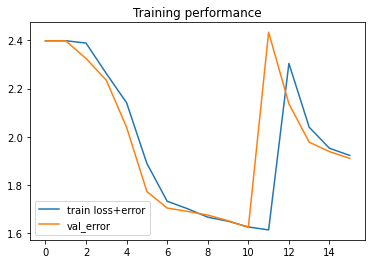

In [ ]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(110000, 128, 2)
For LSTM with Attention
Number of signals: 110000
Average time per perdiction: 0.035066215718180416
Total Time taken: 3.857283728999846


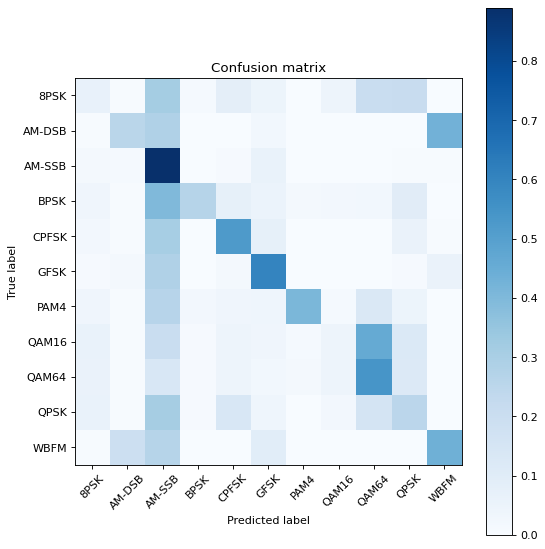

In [ ]:
print(X_test.shape)
start_time = time.perf_counter()
test_Y_hat = model.predict(X_test, batch_size=batch_size)
end_time = time.perf_counter()
avg_time = (end_time - start_time)/X_test.shape[0]
print("For LSTM with Attention")
print("Number of signals: " + str(X_test.shape[0]) )
print("Average time per perdiction: " + str(avg_time * 1e3))
print("Total Time taken: " + str(end_time-start_time))

conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plt.figure(figsize=(7, 7), dpi=80)

plot_confusion_matrix(confnorm, labels=classes)


Overall Accuracy:  0.09039341262580054
Overall Accuracy:  0.09264305177111716
Overall Accuracy:  0.09044862518089725
Overall Accuracy:  0.09635510645976182
Overall Accuracy:  0.1276207839562443
Overall Accuracy:  0.1864226052958948
Overall Accuracy:  0.24784126400881867
Overall Accuracy:  0.32991202346041054


KeyboardInterrupt: ignored

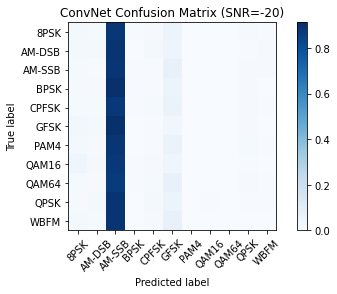

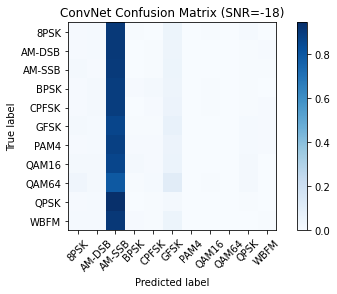

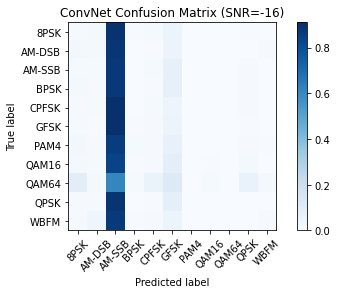

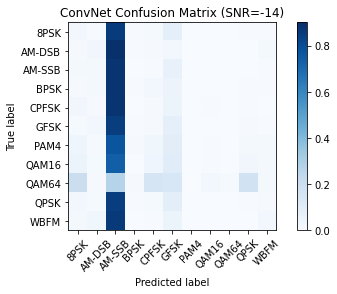

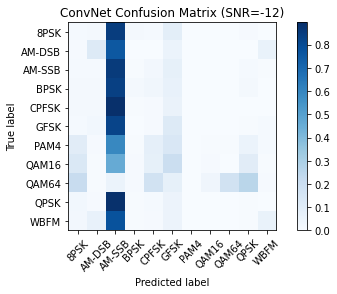

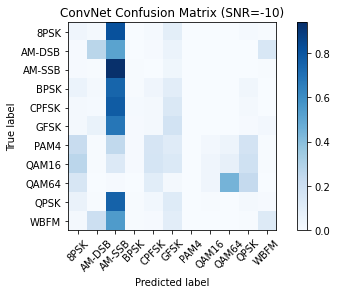

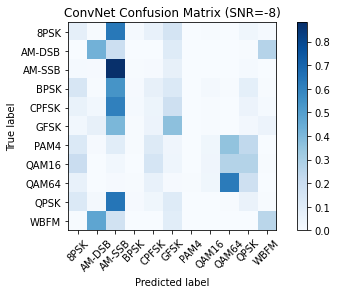

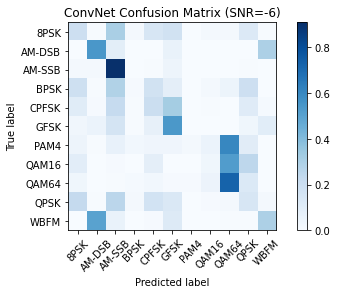

In [ ]:
acc = {}
test_SNRs = np.array( list(map(lambda x: lbl[x][1], test_idx) ) )
for snr in snrs:

    # extract classes @ SNR
    #print(np.where(np.array(test_SNRs))==snr)
    #test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    #test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    test_X_i = X_test[np.nonzero(test_SNRs == snr)]
    test_Y_i = Y_test[np.nonzero(test_SNRs == snr)]
    #test_X_i = np.expand_dims( test_X_i, axis = 1 )
    if ( test_X_i.shape[0] == 0 ):
      continue
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i, batch_size = 1024 )
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)